In [1]:
#csvファイルを読み込む
import pandas as pd

# ファイルパス（適宜変更してください）
file_path = "sweden_energy_transition.csv"

# 読み込み
df = pd.read_csv(file_path)

# 先頭5行を確認
print(df.head())

# データの概要
print(df.info())



   year  draught \nanimal \nenergy  human \nenergy  humene \nfor \nwork  \
0  1800                       12.6            9.29                 1.56   
1  1801                       12.7            9.33                 1.57   
2  1802                       12.8            9.40                 1.59   
3  1803                       12.9            9.47                 1.60   
4  1804                       13.0            9.54                 1.62   

   humene \nfor \nfinal \nconsump \n-tion   total \nanimate \nenergy  \
0                                     7.73                     21.89   
1                                     7.75                     22.03   
2                                     7.81                     22.20   
3                                     7.87                     22.37   
4                                     7.92                     22.54   

   fire-\nwood \nhouse-\nholds  fire-\nwood \nindustry   \
0                        75.90                     7.62  

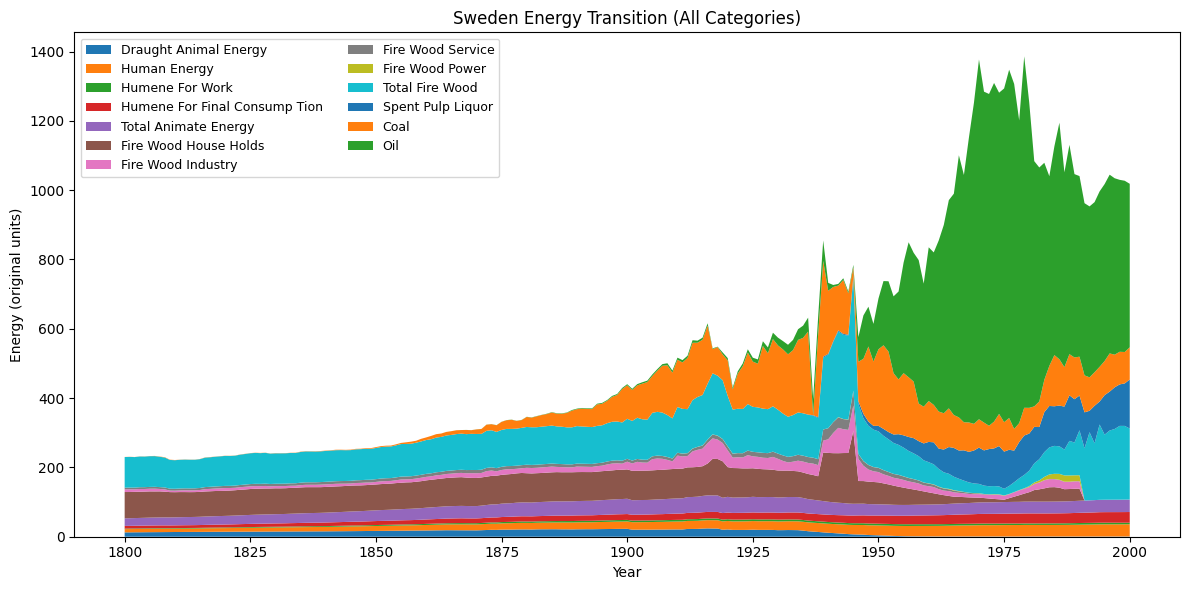

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === 設定 ===
file_path = "sweden_energy_transition.csv"  # 実際のCSVファイル名に合わせる
USE_SHARES = False  # Trueにすると各年100%で割合の積み上げ

# === ヘルパー ===
def clean_col(s: str) -> str:
    s = re.sub(r"[\r\n]+", " ", str(s)).strip()
    s = re.sub(r"\s*-\s*", "_", s)
    s = re.sub(r"\s+", "_", s)
    return s.lower()

# === 読み込み ===
df_raw = pd.read_csv(file_path, header=None)
# 最初に4桁の年が出る行をデータ開始とみなす
year_row_idx = df_raw.apply(lambda r: bool(re.match(r"^\s*\d{4}\s*$", str(r.iloc[0]))), axis=1).idxmax()
header_idx = max(0, year_row_idx - 1)
cols = df_raw.iloc[header_idx].map(clean_col).tolist()
df = df_raw.iloc[year_row_idx:].copy()
df.columns = cols[: len(df.columns)]

# 年列を特定
year_col = None
for c in df.columns:
    if "year" in c:
        year_col = c
        break
if year_col is None:
    year_col = df.columns[0]

# 数値化
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
for c in df.columns:
    if c != year_col:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[year_col]).sort_values(year_col).reset_index(drop=True)

# === 全列使用 ===
energy_cols = [c for c in df.columns if c != year_col]
Y = df[energy_cols].fillna(0).copy()

# 割合にしたい場合
if USE_SHARES:
    row_sum = Y.sum(axis=1).replace(0, np.nan)
    Y = Y.div(row_sum, axis=0) * 100.0
    y_label = "Share (%)"
else:
    y_label = "Energy (original units)"

labels = [re.sub(r"_", " ", c).title() for c in energy_cols]

# === 積み上げグラフ ===
plt.figure(figsize=(12, 6))
plt.stackplot(df[year_col], *[Y[c] for c in energy_cols], labels=labels)
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.xlabel("Year")
plt.ylabel(y_label)
plt.title("Sweden Energy Transition (All Categories)")
plt.tight_layout()
plt.show()


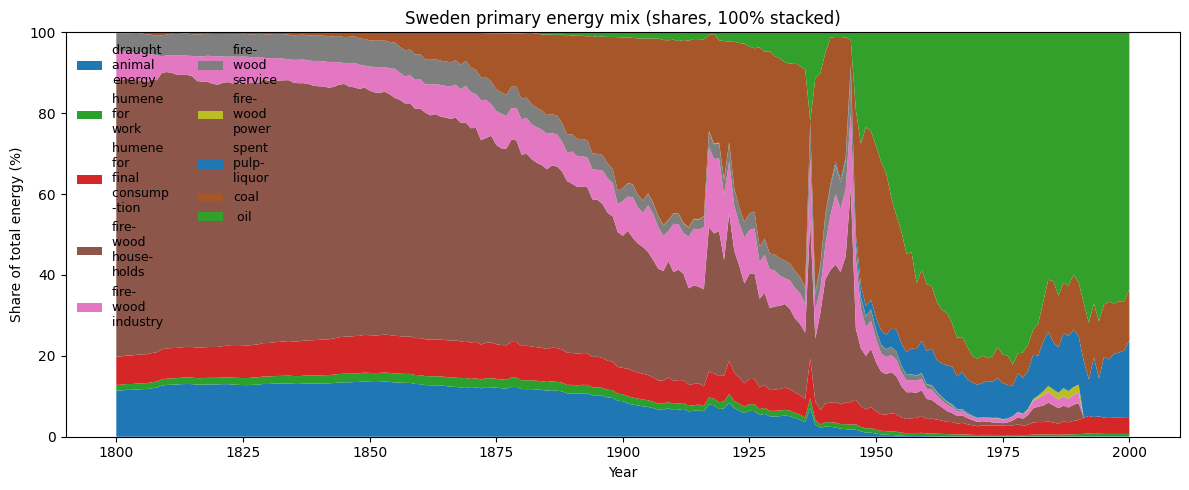

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

file_path = "sweden_energy_transition.csv"

# ---- load (ヘッダはそのまま) ----
df = pd.read_csv(file_path)
year_col = df.columns[0]
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[year_col]).sort_values(year_col).reset_index(drop=True).fillna(0)

# ---- 正規化ヘルパ（照合専用・列名は変更しない） ----
def norm(s: str) -> str:
    s = re.sub(r"\s+", " ", str(s).strip().lower())
    s = s.replace("liqour", "liquor").replace("liquour", "liquor")  # スペル揺れ補正（照合のみ）
    return s

raw_cols = [c for c in df.columns if c != year_col]
norm_map = {c: norm(c) for c in raw_cols}

def find_col(*keywords):
    """キーワード全部を含む列を返す（最初に見つかった1本）。"""
    keys = [norm(k) for k in keywords]
    for raw, nm in norm_map.items():
        if all(k in nm for k in keys):
            return raw
    return None

# ---- 二重計上を避ける“基礎系列”を自動特定 ----
c_draught = find_col("draught", "animal", "energy")
c_work    = find_col("hum", "work")                          # humene/human 両対応
c_final   = find_col("hum", "final", "consump")              # consump tion / consumption 両対応
c_fhh     = find_col("fire", "wood", "house")                # house holds 両対応
c_find    = find_col("fire", "wood", "industry")
c_fserv   = find_col("fire", "wood", "service")
c_fpow    = find_col("fire", "wood", "power")
c_spl     = find_col("spent", "pulp", "liquor")
c_coal    = find_col("coal")
c_oil     = find_col("oil")

energy_cols = [c for c in [c_draught, c_work, c_final, c_fhh, c_find, c_fserv, c_fpow, c_spl, c_coal, c_oil] if c]

# ---- 保険：もし上で1本も見つからなければ、合計列っぽいものを除いて全部使う ----
if not energy_cols:
    energy_cols = [c for c in raw_cols if not re.search(r"(?i)\btotal\b", c)]
    # Human Energy / Total Animate Energy / Total Fire Wood を個別除外（あれば）
    energy_cols = [c for c in energy_cols if norm_map[c] not in
                   {norm("human energy"), norm("total animate energy"), norm("total fire wood")}]

# ---- 100%化 ----
Y = df[energy_cols]
row_sum = Y.sum(axis=1).replace(0, np.nan)
share = Y.div(row_sum, axis=0) * 100.0

# ---- 配色（前回と同じ）を“カテゴリ→実際の列”に対応づけ ----
base_colors = {
    "draught": "#1f77b4",
    "human work": "#2ca02c",
    "human final": "#d62728",
    "fire wood households": "#8c564b",
    "fire wood industry": "#e377c2",
    "fire wood service": "#7f7f7f",
    "fire wood power": "#bcbd22",
    "spent pulp liquor": "#1f78b4",
    "coal": "#a65628",
    "oil": "#33a02c",
}
col2color = {}
if c_draught: col2color[c_draught] = base_colors["draught"]
if c_work:    col2color[c_work]    = base_colors["human work"]
if c_final:   col2color[c_final]   = base_colors["human final"]
if c_fhh:     col2color[c_fhh]     = base_colors["fire wood households"]
if c_find:    col2color[c_find]    = base_colors["fire wood industry"]
if c_fserv:   col2color[c_fserv]   = base_colors["fire wood service"]
if c_fpow:    col2color[c_fpow]    = base_colors["fire wood power"]
if c_spl:     col2color[c_spl]     = base_colors["spent pulp liquor"]
if c_coal:    col2color[c_coal]    = base_colors["coal"]
if c_oil:     col2color[c_oil]     = base_colors["oil"]

# 未指定の列（fallback）は灰色
colors = [col2color.get(c, "#cccccc") for c in energy_cols]

# ---- プロット ----
plt.figure(figsize=(12, 5))
plt.stackplot(df[year_col], *[share[c] for c in energy_cols],
              labels=energy_cols, colors=colors)
plt.xlabel("Year"); plt.ylabel("Share of total energy (%)")
plt.title("Sweden primary energy mix (shares, 100% stacked)")
plt.ylim(0, 100)
plt.legend(loc="upper left", ncol=2, fontsize=9, frameon=False)
plt.tight_layout(); plt.show()
